In [1]:
%pip install neural_tangents

INFO: pip is looking at multiple versions of tf2jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


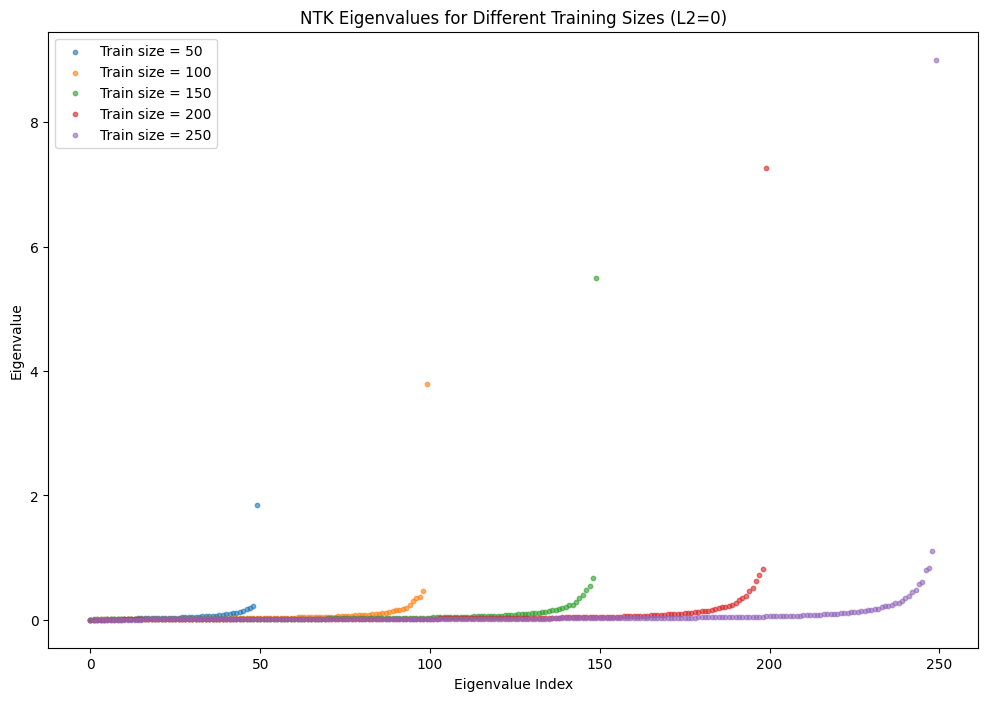

In [2]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10) 
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  
    return eigvals

def train_mlp_with_fixed_l2(x_train, y_train, train_size, epochs=100, learning_rate=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp()
    _, params = init_fn(key, (-1, 28*28))  

    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))

    grad_fn = grad(loss_fn)

    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn 

def track_eigenvalues_with_data_sizes(x_train, y_train, train_sizes, epochs=100):
    final_eigenvalues = {}
    for train_size in train_sizes:
        params, apply_fn = train_mlp_with_fixed_l2(x_train, y_train, train_size, epochs)
        eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
        final_eigenvalues[train_size] = eigvals

    return final_eigenvalues

(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50, 100, 150, 200, 250] 
final_eigenvalues = track_eigenvalues_with_data_sizes(x_train, y_train, train_sizes)
plt.figure(figsize=(12, 8))
for train_size in train_sizes:
    eigvals = final_eigenvalues[train_size]
    plt.scatter(range(len(eigvals)), eigvals, label=f'Train size = {train_size}', alpha=0.6, s=10)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different Training Sizes (L2=0)")
plt.show()

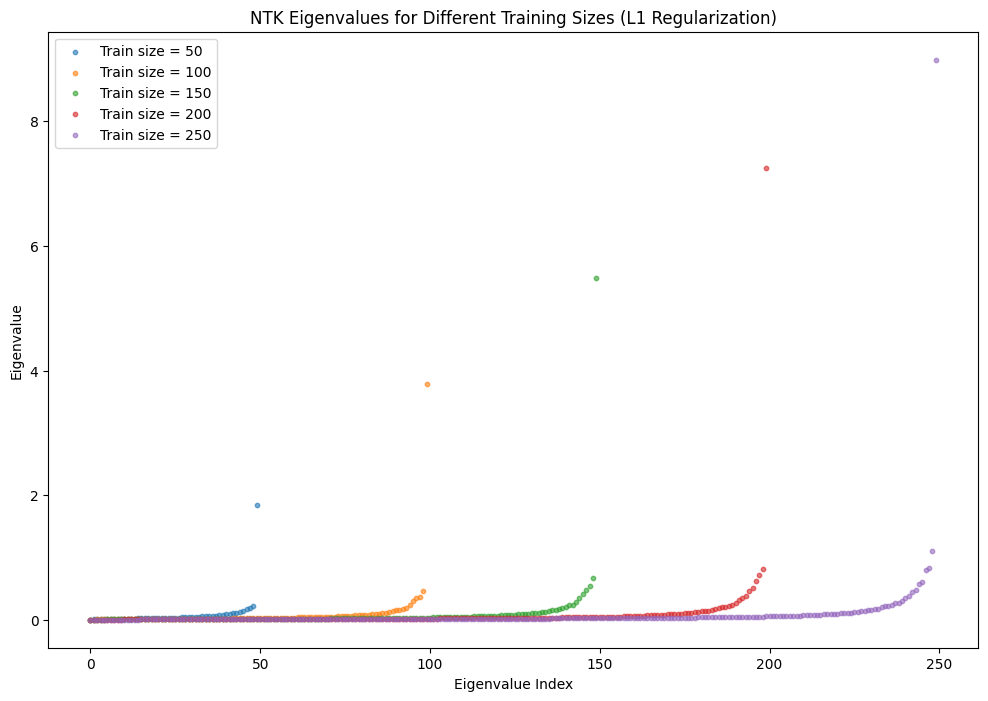

In [3]:
import jax
jax.config.update("jax_enable_x64", False) 
import jax.numpy as jnp
from jax import grad, jit, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

# Load MNIST data
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

# Define a small MLP model
def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(128), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

# Compute NTK eigenvalues after training
def compute_empirical_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params=params)
    eigvals = eigh(ntk_matrix)[0]  # Compute eigenvalues
    return eigvals

# Training function with L1 regularization
def train_mlp_with_l1(x_train, y_train, train_size, epochs=100, learning_rate=0.01, l1_lambda=0.001):
    key = random.PRNGKey(0)
    init_fn, apply_fn, kernel_fn = create_mlp()
    _, params = init_fn(key, (-1, 28*28))  # Initialize model parameters

    # Define loss function with L1 regularization
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        ce_loss = jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1))  # Cross-entropy loss
        l1_loss = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))  # L1 norm
        return ce_loss + l1_lambda * l1_loss  # Combined loss

    # Get gradients
    grad_fn = grad(loss_fn)

    # Training loop
    for epoch in range(epochs):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])  # Train on subset
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

    return params, apply_fn  # Return trained parameters and function

# Train model with different training sizes while applying L1 regularization
def track_eigenvalues_with_data_sizes(x_train, y_train, train_sizes, epochs=100, l1_lambda=0.001):
    final_eigenvalues = {}
    for train_size in train_sizes:
        params, apply_fn = train_mlp_with_l1(x_train, y_train, train_size, epochs, l1_lambda=l1_lambda)
        eigvals = compute_empirical_ntk_eigenvalues(apply_fn, params, x_train[:train_size])  # Compute NTK after training
        final_eigenvalues[train_size] = eigvals

    return final_eigenvalues

# Main execution
(x_train, y_train), (x_test, y_test) = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different dataset sizes
l1_lambda = 0.001  # L1 regularization strength
final_eigenvalues = track_eigenvalues_with_data_sizes(x_train, y_train, train_sizes, l1_lambda=l1_lambda)

# Plot eigenvalues for different training sizes
plt.figure(figsize=(12, 8))
for train_size in train_sizes:
    eigvals = final_eigenvalues[train_size]
    plt.scatter(range(len(eigvals)), eigvals, label=f'Train size = {train_size}', alpha=0.6, s=10)

plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.legend()
plt.title("NTK Eigenvalues for Different Training Sizes (L1 Regularization)")
plt.show()


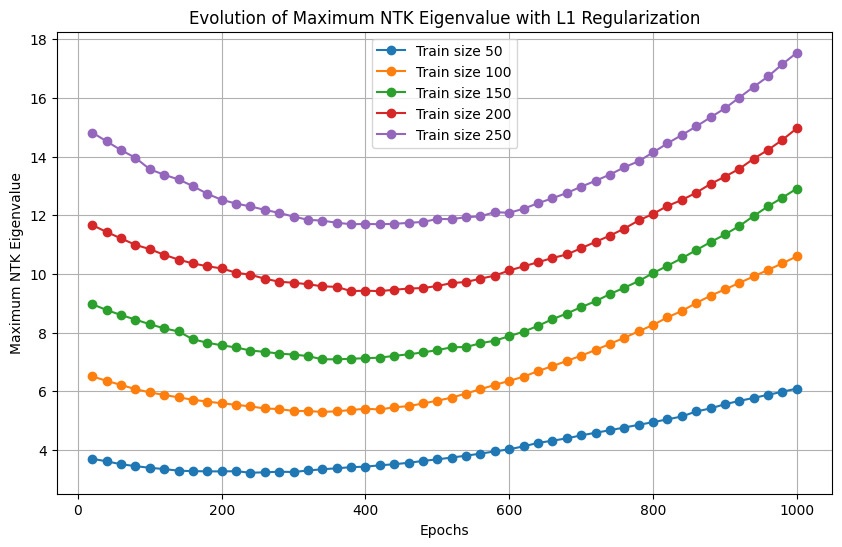

In [4]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l1=0.0001):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l1_loss = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))  # L1 norm
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l1 * l1_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue with L1 Regularization")
plt.legend()
plt.grid(True)
plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


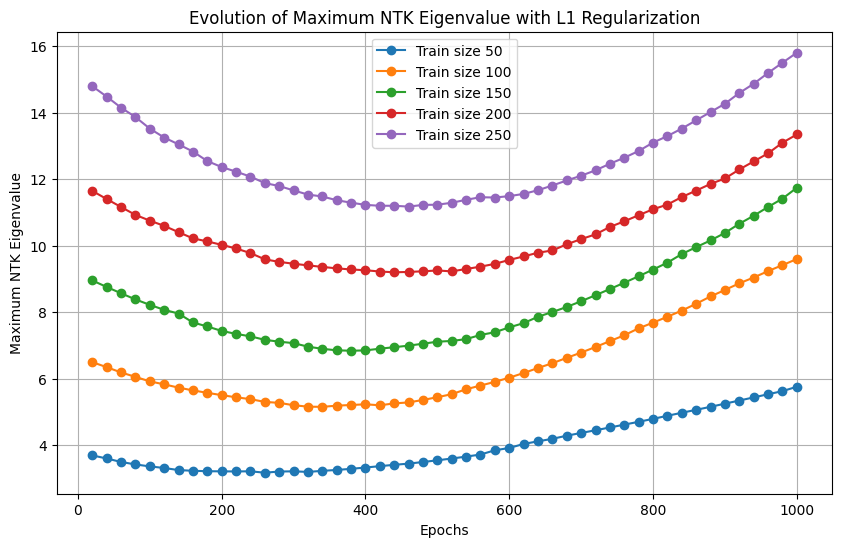

In [3]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l1=0.001):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l1_loss = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))  # L1 norm
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l1 * l1_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue with L1 Regularization")
plt.legend()
plt.grid(True)
plt.show()


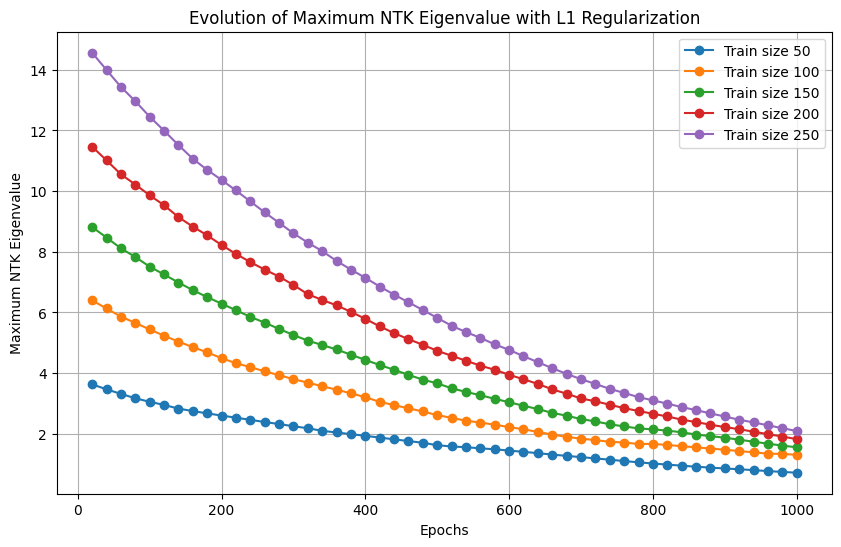

In [5]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l1=0.01):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l1_loss = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))  # L1 norm
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l1 * l1_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue with L1 Regularization")
plt.legend()
plt.grid(True)
plt.show()


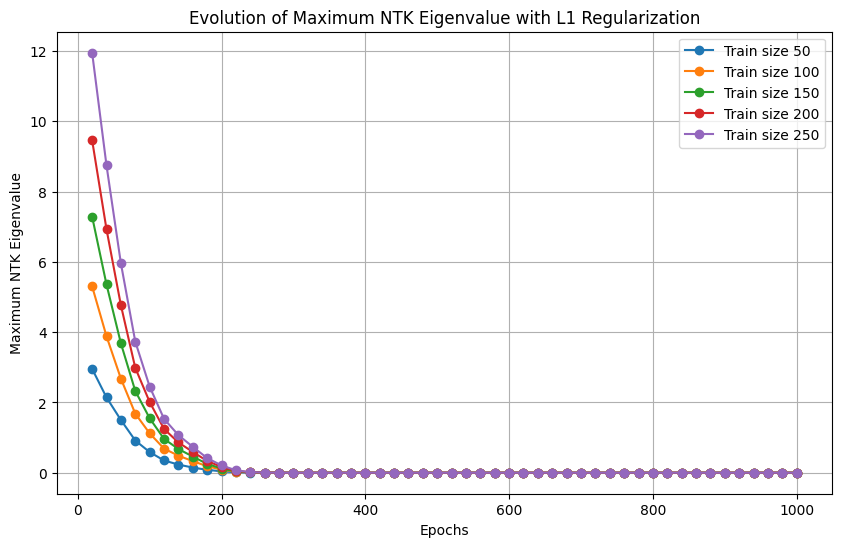

In [8]:
import jax
jax.config.update("jax_enable_x64", False)
import jax.numpy as jnp
from jax import grad, random
from jax.scipy.linalg import eigh
import neural_tangents as nt
from neural_tangents import stax
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
    x_train, x_test = x_train.reshape(-1, 28*28), x_test.reshape(-1, 28*28)  # Flatten
    y_train, y_test = jax.nn.one_hot(y_train, 10), jax.nn.one_hot(y_test, 10)  # One-hot encoding
    return (x_train, y_train), (x_test, y_test)

def create_mlp():
    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(4), stax.Relu(),
        stax.Dense(10)
    )
    return init_fn, apply_fn, kernel_fn

def compute_ntk_eigenvalues(apply_fn, params, x_train):
    empirical_kernel_fn = nt.empirical_ntk_fn(apply_fn, vmap_axes=0)
    ntk_matrix = empirical_kernel_fn(x_train, x_train, params)
    if ntk_matrix.ndim == 3:
        ntk_matrix = ntk_matrix.mean(axis=-1)
    eigvals = eigh(ntk_matrix)[0]
    return eigvals

def train_and_track_ntk(x_train, y_train, train_size, epochs=1000, learning_rate=0.1, l1=0.1):
    key = random.PRNGKey(0)
    init_fn, apply_fn, _ = create_mlp()
    _, params = init_fn(key, (-1, 28*28))
    
    def loss_fn(params, x, y):
        logits = apply_fn(params, x)
        l1_loss = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))  # L1 norm
        return jnp.mean(jnp.sum(-y * jax.nn.log_softmax(logits), axis=1)) + l1 * l1_loss
    
    grad_fn = grad(loss_fn)
    max_eigenvalues = {}
    
    for epoch in range(1, epochs + 1):
        grads = grad_fn(params, x_train[:train_size], y_train[:train_size])
        params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)
        
        if epoch % 20 == 0:
            eigvals = compute_ntk_eigenvalues(apply_fn, params, x_train[:train_size])
            max_eigenvalues[epoch] = jnp.max(eigvals)
    
    return max_eigenvalues

(x_train, y_train), _ = load_mnist()
train_sizes = [50, 100, 150, 200, 250]  # Different training sizes
epochs = 1000

plt.figure(figsize=(10, 6))
for size in train_sizes:
    max_eigenvalues = train_and_track_ntk(x_train, y_train, size, epochs)
    plt.plot(list(max_eigenvalues.keys()), list(max_eigenvalues.values()), marker='o', linestyle='-', label=f"Train size {size}")

plt.xlabel("Epochs")
plt.ylabel("Maximum NTK Eigenvalue")
plt.title("Evolution of Maximum NTK Eigenvalue with L1 Regularization")
plt.legend()
plt.grid(True)
plt.show()
